<a href="https://colab.research.google.com/github/vikashkodati/mygig/blob/main/langgraph_customised_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langsmith langchain_community langchain tavily-python langchain-google-genai pprintpp langchain-core langchain_anthropic

In [ ]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START , END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [ ]:
#define a schema to show the model to let it decide to request assistance.

from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [ ]:
# ANTHROPIC
import os
os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC")
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

In [ ]:
# openai
'''
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API")

from langchain_community.chat_models import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=200,
    timeout=None,
    max_retries=2
)
'''

In [ ]:
from google.colab import userdata
import os
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
# open ai
'''
from langchain_google_genai import ChatGoogleGenerativeAI
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2)

'''

'\nfrom langchain_google_genai import ChatGoogleGenerativeAI\nif "GOOGLE_API_KEY" not in os.environ:\n    os.environ["GOOGLE_API_KEY"] = userdata.get(\'GOOGLE_API_KEY\')\nllm = ChatGoogleGenerativeAI(\n    model="gemini-1.5-pro",\n    temperature=0,\n    max_tokens=None,\n    timeout=None,\n    max_retries=2)\n\n'

In [ ]:
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search,max_result= 2)
tool=tavily_tool
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"},
 {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787',
  'content': "However, LangGraph brings a bunch of additional concepts. Let's discuss them. LangGraph is created to define cyclical graphs. Graphs consist of the following ele

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [ ]:
# create the graph builder and add the chatbot and tools nodes to the graph, same as before.
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

define the conditional logic. The select_next_node will route to the human node if the flag is set. Otherwise, it lets the prebuilt tools_condition function choose the next node.

Recall that the tools_condition function simply checks to see if the chatbot has responded with any tool_calls in its response message. If so, it routes to the action node. Otherwise, it ends the graph

In [ ]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

 add the simple directed edges and compile the graph. These edges instruct the graph to always flow from node a->b whenever a finishes executing.

In [ ]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

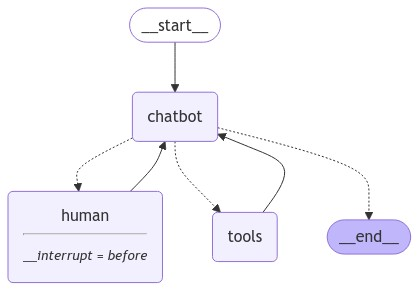

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Anthropic API. Please go to Plans & Billing to upgrade or purchase credits.'}}

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

In [ ]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

In [ ]:
graph.get_state(config).values["messages"]

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()